# Self made RP3-beta

In [2]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [3]:
class RP3Beta():
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui=train_ui
        self.train_iu=train_ui.transpose()
        
        self.alpha = alpha
        self.beta = beta
        
        # Define Pui 
        Pui=sparse.csr_matrix(self.train_ui/self.train_ui.sum(axis=1))
        
        # Define Piu
        to_divide=np.vectorize(lambda x: x if x>0 else 1)(self.train_iu.sum(axis=1)) # to avoid dividing by zero
        Piu=sparse.csr_matrix(self.train_iu/to_divide)
        item_orders=(self.train_ui>0).sum(axis=0)
        
        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3=Pui*Piu*Pui
        
        P3/=np.power(np.vectorize(lambda x: x if x>0 else 1)(item_orders), self.beta)
        
        self.estimations=np.array(P3)
    
    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [4]:
model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [5]:
top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_P3_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', index=False, header=False)

In [6]:
import evaluation_measures as ev
estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_P3_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 11083.98it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.875928  0.181702       0.340803           1.0       0.077201  3.875892   

       Gini  
0  0.974947

# Let's check hiperparameters

##### Alpha

In [7]:
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)
    
result=pd.concat(result)
result

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]
943it [00:00, 10829.24it/s]
 12%|██████████▌                                                                         | 1/8 [00:07<00:54,  7.76s/it]
943it [00:00, 10352.86it/s]
 25%|█████████████████████                                                               | 2/8 [00:15<00:46,  7.74s/it]
943it [00:00, 10130.29it/s]
 38%|███████████████████████████████▌                                                    | 3/8 [00:23<00:38,  7.75s/it]
943it [00:00, 10130.62it/s]
 50%|██████████████████████████████████████████                                          | 4/8 [00:30<00:30,  7.74s/it]
943it [00:00, 10240.79it/s]
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:38<00:23,  7.79s/it]
943it [00:00, 10585.44it/s]
 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:46<00:15,  7.

Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.850477  0.159293       0.321247      1.000000       0.060606  3.669627   
0  0.854719  0.164747       0.326323      1.000000       0.064214  3.726996   
0  0.870626  0.171652       0.333140      1.000000       0.065657  3.785282   
0  0.874867  0.179823       0.340076      1.000000       0.070707  3.832415   
0  0.875928  0.181702       0.340803      1.000000       0.077201  3.875892   
0  0.883351  0.182776       0.341341      1.000000       0.085859  3.910718   
0  0.871686  0.179766       0.336190      1.000000       0.107504  3.961915   
0  0.868505  0.175419       0.328868      0.999576       0.156566  4.060156   

       Gini  
0  0.979636  
0  0.978426  
0  0.977090  
0  0.975998  
0  0.974947  
0  0.974073  
0  0.972674  
0  0.969203

IndexError: list index out of range

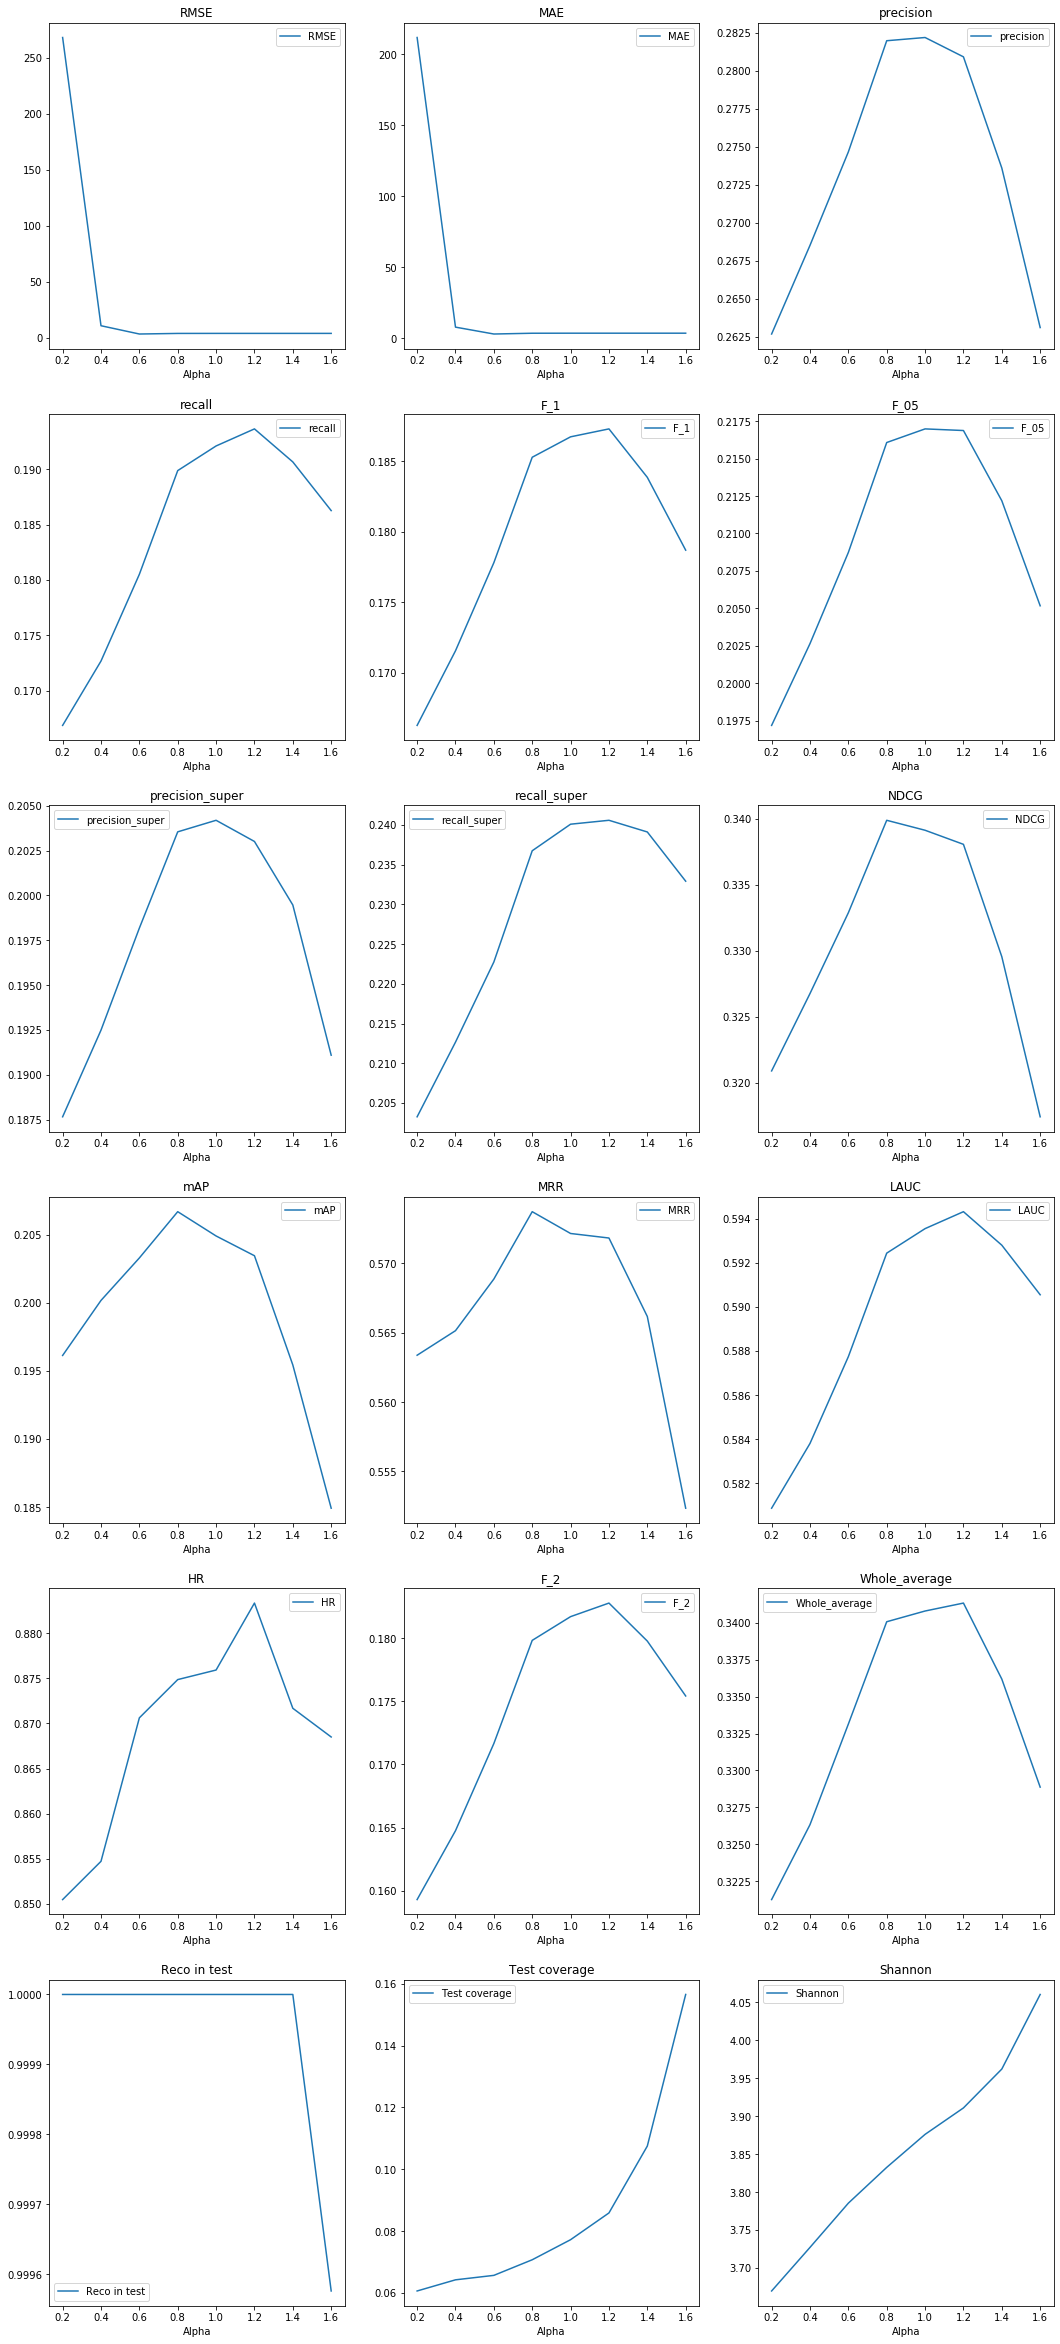

In [9]:
metrics=list(result.columns[[i not in ['Alpha'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Alpha', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [19]:
from tqdm import tqdm
result=[]
for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
    model=RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=np.array(reco),
            super_reactions=[4,5])
    to_append.insert(0, "Beta", beta)
    result.append(to_append)
    
result=pd.concat(result)
result



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


943it [00:00, 10022.73it/s]


 10%|████████▎                                                                          | 1/10 [00:07<01:10,  7.79s/it]


943it [00:00, 10353.16it/s]


 20%|████████████████▌                                                                  | 2/10 [00:15<01:02,  7.81s/it]


943it [00:00, 10130.44it/s]


 30%|████████████████████████▉                                                          | 3/10 [00:23<00:55,  7.86s/it]


943it [00:00, 10535.95it/s]


 40%|█████████████████████████████████▏                                                 | 4/10 [00:31<00:47,  7.93s/it]


943it [00:00, 9917.28it/s]A


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:39<00:39,  7.89s/it]


943it [00:00, 10130.55it/s]


 60%|█████████████████████████████████████████████████▊                               

Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0  0.875928  0.181702       0.340803      1.000000       0.077201  3.875892   
0  0.884411  0.187030       0.347420      1.000000       0.085137  3.957416   
0  0.886532  0.190538       0.352756      1.000000       0.094517  4.053212   
0  0.888653  0.194073       0.358344      1.000000       0.105339  4.147779   
0  0.895016  0.197981       0.363598      0.999894       0.132035  4.259682   
0  0.903499  0.200572       0.369318      0.999046       0.168831  4.411281   
0  0.897137  0.197320       0.367854      0.996394       0.212843  4.621938   
0  0.868505  0.182056       0.352330      0.983033       0.256854  4.898568   
0  0.803818  0.146414       0.307476      0.936373       0.341270  5.257397   
0  0.580064  0.078906       0.197947      0.800106       0.415584  5.563910   

       Gini  
0  0.974947  
0  0.972784  
0  0.969980  
0  0.966948  
0  0.962989  
0  0.956648  
0  0.945932  
0  0.928065  
0  0.895882  
0  0.857396

IndexError: list index out of range

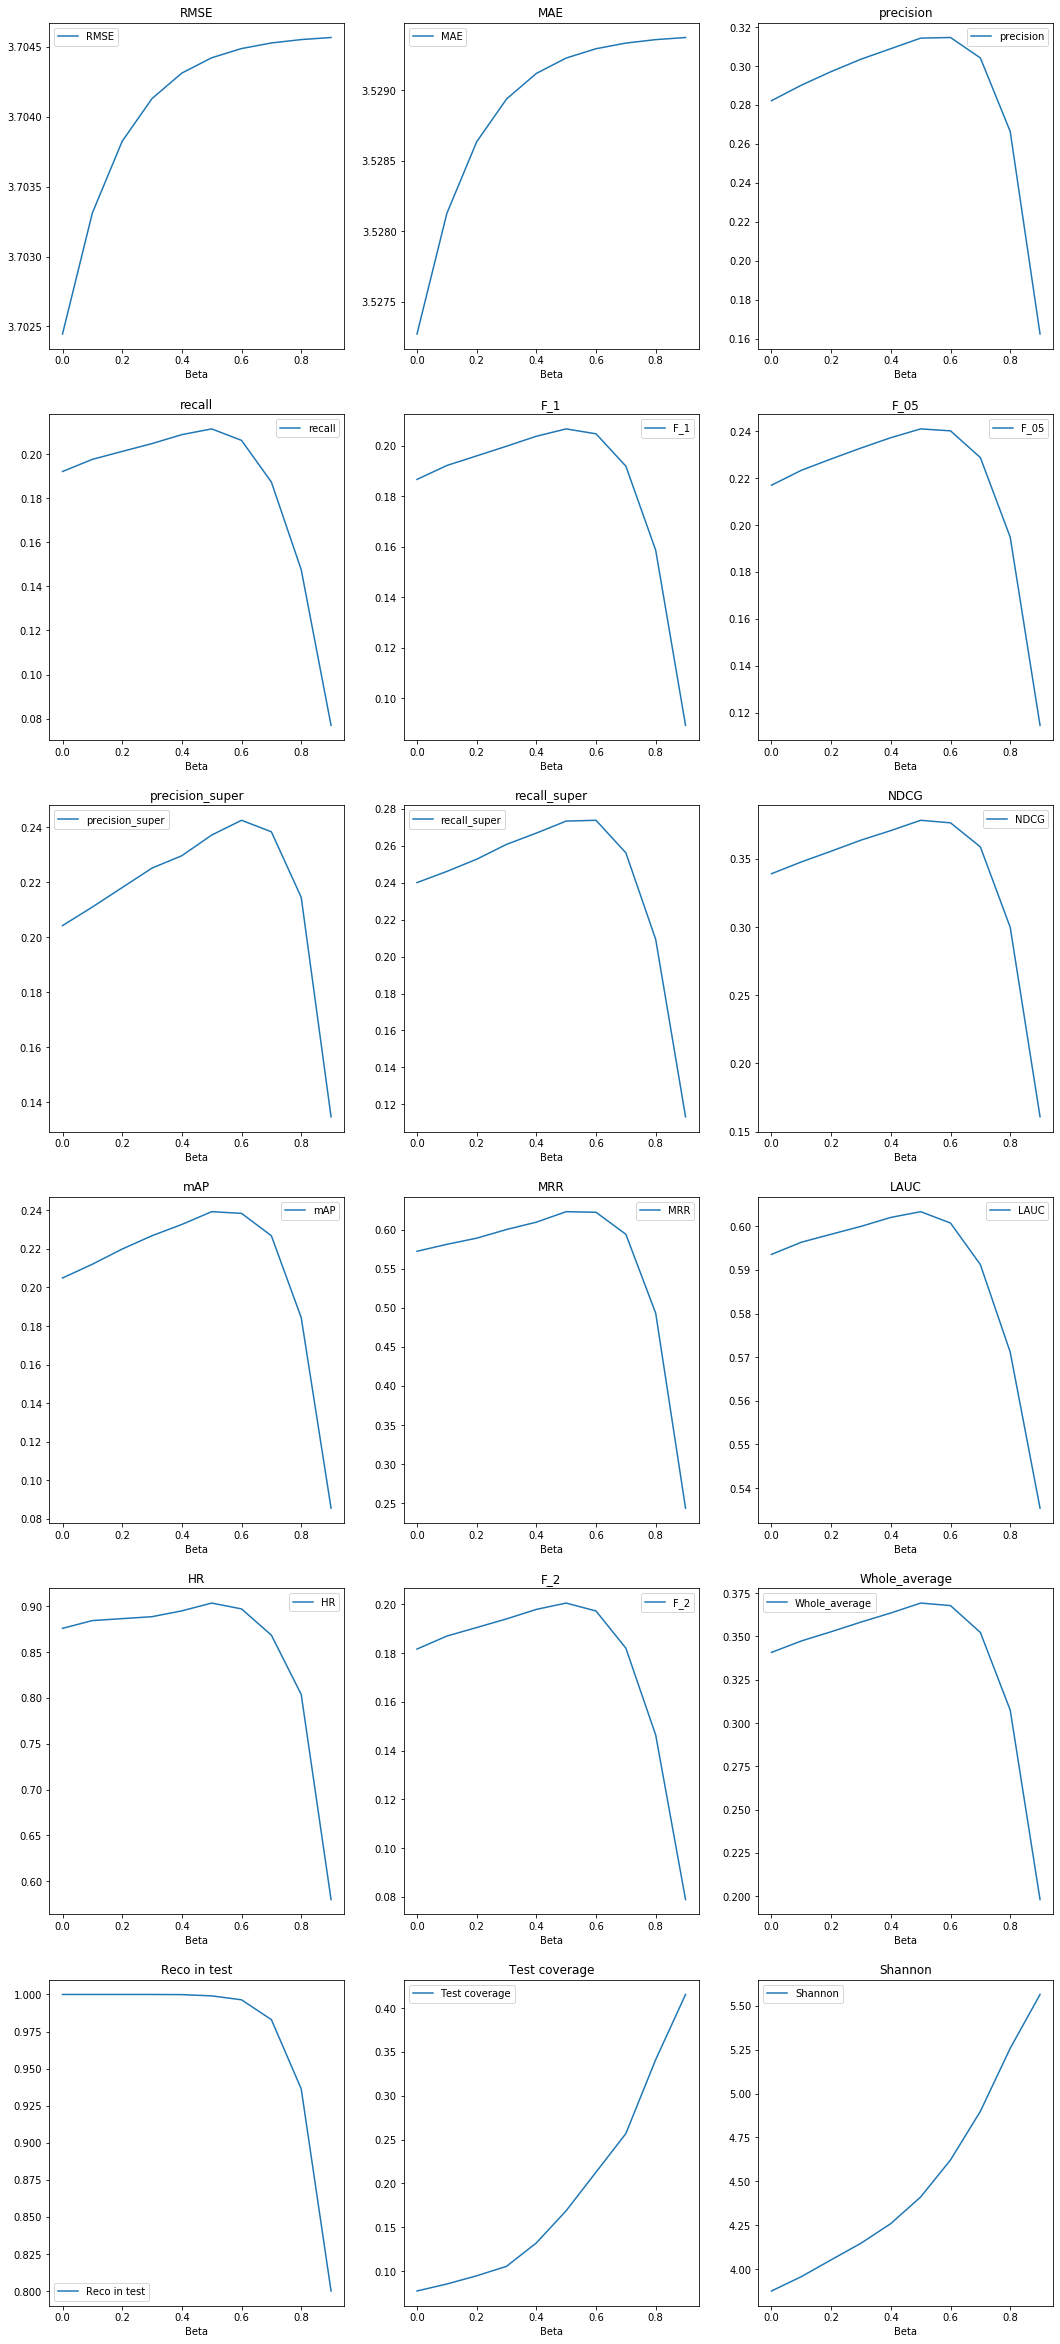

In [20]:
### import matplotlib.pyplot as plt

metrics=list(result.columns[[i not in ['Beta'] for i in result.columns]])

charts_per_row=6
charts_per_column=3

fig, axes = plt.subplots(nrows=charts_per_row, ncols=charts_per_column,figsize=(18, 7*charts_per_row ))
import itertools
to_iter=[i for i in itertools.product(range(charts_per_row), range(charts_per_column))]

for i in range(len(metrics)):
    df=result[['Beta', metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [21]:
train=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

user=random.choice(list(set(train['user'])))

train_content=pd.merge(train, items, left_on='item', right_on='id')
display(train_content[train_content['user']==user][['user', 'rating', 'title', 'genres']]\
        .sort_values(by='rating', ascending=False)[:15])

reco = np.loadtxt('Recommendations generated/ml-100k/Self_P3_reco.csv', delimiter=',')
items=pd.read_csv('./Datasets/ml-100k/movies.csv')

# Let's ignore scores - they are not used in evaluation: 
reco_users=reco[:,:1]
reco_items=reco[:,1::2]
# Let's put them into one array
reco=np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended=[]
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb+1, entry))
recommended=pd.DataFrame(recommended, columns=['user','rec_nb', 'item'])

recommended_content=pd.merge(recommended, items, left_on='item', right_on='id')
recommended_content[recommended_content['user']==user][['user', 'rec_nb', 'title', 'genres']].sort_values(by='rec_nb')

user  rating                                           title  \
24400   162       5              People vs. Larry Flynt, The (1996)   
2968    162       5                                Star Wars (1977)   
53325   162       5                             Multiplicity (1996)   
338     162       4                                Toy Story (1995)   
75614   162       4  Things to Do in Denver when You're Dead (1995)   
62014   162       4                            Private Parts (1997)   
55054   162       4                 Long Kiss Goodnight, The (1996)   
44658   162       4                                   Ransom (1996)   
39354   162       4                                 Sleepers (1996)   
31559   162       4                            Seven (Se7en) (1995)   
30151   162       4                 Star Trek: First Contact (1996)   
28434   162       4                     2 Days in the Valley (1996)   
28048   162       4                                 Face/Off (1997)   
76062   162       4                              Killing Zoe (1994)   
4876    162       4                                Rock, The (1996)   

                                        genres  
24400                                    Drama  
2968   Action, Adventure, Romance, Sci-Fi, War  
53325                                   Comedy  
338              Animation, Children's, Comedy  
75614                    Crime, Drama, Romance  
62014                            Comedy, Drama  
55054                         Action, Thriller  
44658                          Drama, Thriller  
39354                             Crime, Drama  
31559                          Crime, Thriller  
30151                Action, Adventure, Sci-Fi  
28434                                    Crime  
28048                 Action, Sci-Fi, Thriller  
76062                                 Thriller  
4876               Action, Adventure, Thriller

user  rec_nb                             title  \
6985  162.0       1                      Fargo (1996)   
5656  162.0       2                    Contact (1997)   
2253  162.0       3             Godfather, The (1972)   
8472  162.0       4     Independence Day (ID4) (1996)   
1727  162.0       5                     Scream (1996)   
4478  162.0       6              Air Force One (1997)   
728   162.0       7  Silence of the Lambs, The (1991)   
9100  162.0       8        Mission: Impossible (1996)   
8822  162.0       9               Men in Black (1997)   
6382  162.0      10               Pulp Fiction (1994)   

                                 genres  
6985             Crime, Drama, Thriller  
5656                      Drama, Sci-Fi  
2253               Action, Crime, Drama  
8472                Action, Sci-Fi, War  
1727                   Horror, Thriller  
4478                   Action, Thriller  
728                     Drama, Thriller  
9100         Action, Adventure, Mystery  
8822  Action, Adventure, Comedy, Sci-Fi  
6382                       Crime, Drama

# project task 6: generate recommendations of RP3Beta for hiperparameters found to optimize recall

In [12]:
# use better values than (1,0) for alpha and beta
# if you want you can also modify the model to consider different weights (we took as weights user ratings, maybe take ones or squares of ratings instead)
# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'
from tqdm import tqdm
result=[]
for alpha in tqdm([round(i,1) for i in np.arange(0.2,1.6001,0.2)]):
    for beta in tqdm([round(i,1) for i in np.arange(0,1,0.1)]):
        model=RP3Beta()
        model.fit(train_ui, alpha=alpha, beta=beta)
        reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
        estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
        to_append=ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
                estimations_df=estimations_df, 
                reco=np.array(reco),
                super_reactions=[4,5])
        to_append.insert(0, "Alpha", alpha)
        to_append.insert(0, "Beta", beta)
        result.append(to_append)

result=pd.concat(result)
result



  0%|                                                                                            | 0/8 [00:00<?, ?it/s]


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]



943it [00:00, 10468.33it/s]



 10%|████████▎                                                                          | 1/10 [00:07<01:09,  7.72s/it]



943it [00:00, 10468.25it/s]



 20%|████████████████▌                                                                  | 2/10 [00:15<01:01,  7.73s/it]



943it [00:00, 9917.23it/s]A



 30%|████████████████████████▉                                                          | 3/10 [00:23<00:54,  7.76s/it]



943it [00:00, 10280.82it/s]



 40%|█████████████████████████████████▏                                                 | 4/10 [00:31<00:46,  7.75s/it]



943it [00:00, 10130.05it/s]



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:39<00:3

Beta  Alpha        RMSE         MAE  precision    recall       F_1  \
0    0.0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277   
0    0.1    0.2  157.599233  126.908903   0.270201  0.172173  0.171630   
0    0.2    0.2   92.637651   75.868627   0.276776  0.176262  0.175719   
0    0.3    0.2   54.292373   45.040060   0.285366  0.186535  0.183212   
0    0.4    0.2   31.548217   26.348648   0.294168  0.195917  0.190517   
..   ...    ...         ...         ...        ...       ...       ...   
0    0.5    1.6    3.704592    3.529400   0.252810  0.168829  0.166131   
0    0.6    1.6    3.704592    3.529400   0.232344  0.149823  0.149912   
0    0.7    1.6    3.704592    3.529400   0.190668  0.114377  0.119136   
0    0.8    1.6    3.704592    3.529400   0.128420  0.074778  0.078618   
0    0.9    1.6    3.704592    3.529400   0.053128  0.032647  0.034075   

        F_05  precision_super  recall_super  ...       mAP       MRR  \
0   0.197184         0.187661      0.203252  ...  0.196132  0.563378   
0   0.203289         0.193455      0.210058  ...  0.204201  0.574015   
0   0.208241         0.198712      0.215199  ...  0.212735  0.586185   
0   0.215805         0.206330      0.228824  ...  0.221257  0.599301   
0   0.223387         0.212339      0.237213  ...  0.232274  0.613992   
..       ...              ...           ...  ...       ...       ...   
0   0.193923         0.194099      0.222324  ...  0.172320  0.507818   
0   0.176682         0.182618      0.202454  ...  0.149266  0.447627   
0   0.142966         0.153433      0.156962  ...  0.108990  0.338688   
0   0.095479         0.104614      0.104027  ...  0.058852  0.195718   
0   0.040718         0.042060      0.041190  ...  0.016389  0.070535   

        LAUC        HR       F_2  Whole_average  Reco in test  Test coverage  \
0   0.580866  0.850477  0.159293       0.321247      1.000000       0.060606   
0   0.583558  0.854719  0.164471       0.327693      1.000000       0.069264   
0   0.585642  0.856840  0.168325       0.333365      1.000000       0.073593   
0   0.590800  0.866384  0.176715       0.342608      1.000000       0.080087   
0   0.595531  0.873807  0.184624       0.351439      1.000000       0.090909   
..       ...       ...       ...            ...           ...            ...   
0   0.581757  0.832450  0.160691       0.312473      0.978685       0.324675   
0   0.572141  0.793213  0.143766       0.288652      0.956734       0.375180   
0   0.554239  0.714740  0.112032       0.242561      0.917391       0.422799   
0   0.534170  0.576882  0.073268       0.179234      0.848993       0.461760   
0   0.512829  0.318134  0.032001       0.103351      0.751856       0.458874   

     Shannon      Gini  
0   3.669627  0.979636  
0   3.755959  0.977793  
0   3.853614  0.975477  
0   3.975583  0.972148  
0   4.135455  0.967171  
..       ...       ...  
0   4.885124  0.923658  
0   5.163474  0.899700  
0   5.439353  0.871133  
0   5.645544  0.844059  
0   5.549901  0.851786  

[80 rows x 21 columns]

In [15]:
result.sort_values(["recall"])

Beta  Alpha      RMSE       MAE  precision    recall       F_1      F_05  \
0    0.9    0.2  1.924999  1.578969   0.046872  0.029500  0.030577  0.036250   
0    0.9    1.6  3.704592  3.529400   0.053128  0.032647  0.034075  0.040718   
0    0.9    1.4  3.704592  3.529400   0.083987  0.043380  0.048687  0.061086   
0    0.9    1.2  3.704590  3.529398   0.123754  0.059849  0.068941  0.088107   
0    0.9    0.4  3.570950  3.389375   0.134571  0.074128  0.081566  0.100181   
..   ...    ...       ...       ...        ...       ...       ...       ...   
0    0.7    0.4  3.366117  3.176750   0.325451  0.212663  0.211707  0.248509   
0    0.6    0.6  3.675385  3.499644   0.321209  0.212728  0.210025  0.245804   
0    0.5    0.6  3.657073  3.481191   0.316543  0.213824  0.208731  0.243080   
0    0.6    0.4  3.163972  2.963841   0.321633  0.214651  0.210829  0.246304   
0    0.6    0.8  3.702928  3.527713   0.322694  0.216069  0.212152  0.247538   

    precision_super  recall_super  ...       mAP       MRR      LAUC  \
0          0.026717      0.030322  ...  0.016399  0.087921  0.511252   
0          0.042060      0.041190  ...  0.016389  0.070535  0.512829   
0          0.069850      0.059877  ...  0.031721  0.110366  0.518313   
0          0.103112      0.086342  ...  0.056347  0.173414  0.526691   
0          0.093348      0.089465  ...  0.061490  0.221330  0.533886   
..              ...           ...  ...       ...       ...       ...   
0          0.241845      0.277204  ...  0.254415  0.641002  0.604002   
0          0.240021      0.275765  ...  0.252127  0.641583  0.604033   
0          0.235515      0.272396  ...  0.245543  0.627971  0.604552   
0          0.237554      0.271061  ...  0.254635  0.638867  0.604994   
0          0.245279      0.284983  ...  0.248239  0.636318  0.605683   

          HR       F_2  Whole_average  Reco in test  Test coverage   Shannon  \
0   0.304348  0.028900       0.099565      0.563945       0.386724  5.389109   
0   0.318134  0.032001       0.103351      0.751856       0.458874  5.549901   
0   0.404030  0.043871       0.129225      0.760870       0.437951  5.533867   
0   0.513256  0.061176       0.164812      0.778473       0.428571  5.542104   
0   0.583245  0.074504       0.181723      0.756628       0.475469  5.836152   
..       ...       ...            ...           ...            ...       ...   
0   0.899258  0.203678       0.376005      0.999364       0.212843  4.811161   
0   0.898197  0.202744       0.374524      1.000000       0.157287  4.524904   
0   0.903499  0.202671       0.371481      1.000000       0.125541  4.347845   
0   0.897137  0.204058       0.374418      1.000000       0.152958  4.525149   
0   0.910923  0.205450       0.376967      0.999788       0.178932  4.549663   

        Gini  
0   0.873532  
0   0.851786  
0   0.857181  
0   0.859106  
0   0.814736  
..       ...  
0   0.935129  
0   0.951442  
0   0.959410  
0   0.951375  
0   0.950182  

[80 rows x 21 columns]

In [17]:
model=RP3Beta()
model.fit(train_ui, alpha=0.8, beta=0.6)
reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)

In [18]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)



943it [00:00, 11351.08it/s]


943it [00:00, 11351.15it/s]


943it [00:00, 11351.21it/s]


943it [00:00, 11489.57it/s]


943it [00:00, 11215.96it/s]


943it [00:00, 11489.47it/s]


943it [00:00, 11084.07it/s]


943it [00:00, 10353.19it/s]


943it [00:00, 11489.61it/s]


943it [00:00, 11351.21it/s]


943it [00:00, 10585.92it/s]


943it [00:00, 11489.64it/s]


943it [00:00, 9813.90it/s]


943it [00:00, 11351.21it/s]


943it [00:00, 11215.93it/s]


943it [00:00, 10829.15it/s]


943it [00:00, 10955.13it/s]


943it [00:00, 10706.24it/s]


Model      RMSE       MAE  precision    recall       F_1  \
0          Self_RP3Beta  3.702928  3.527713   0.322694  0.216069  0.212152   
0               Self_P3  3.702446  3.527273   0.282185  0.192092  0.186749   
0           Self_TopPop  2.508258  2.217909   0.188865  0.116919  0.118732   
0      Self_SVDBaseline  3.645871  3.480308   0.135949  0.078868  0.082011   
0             Ready_SVD  0.950835  0.748676   0.097879  0.048335  0.053780   
0              Self_SVD  0.913966  0.717846   0.105514  0.044566  0.054152   
0        Ready_Baseline  0.949459  0.752487   0.091410  0.037652  0.046030   
0       Ready_SVDBiased  0.943277  0.743628   0.080912  0.033048  0.040445   
0  Self_KNNSurprisetask  0.946255  0.745209   0.083457  0.032848  0.041227   
0         Self_TopRated  2.508258  2.217909   0.079321  0.032667  0.039983   
0        Self_GlobalAvg  1.125760  0.943534   0.061188  0.025968  0.031383   
0          Ready_Random  1.525730  1.225537   0.045917  0.020462  0.023786   
0           Ready_I-KNN  1.030386  0.813067   0.026087  0.006908  0.010593   
0   Ready_I-KNNBaseline  0.935327  0.737424   0.002545  0.000755  0.001105   
0           Ready_U-KNN  1.023495  0.807913   0.000742  0.000205  0.000305   
0       Self_BaselineIU  0.958136  0.754051   0.000954  0.000188  0.000298   
0       Self_BaselineUI  0.967585  0.762740   0.000954  0.000170  0.000278   
0             Self_IKNN  1.018363  0.808793   0.000318  0.000108  0.000140   

       F_05  precision_super  recall_super      NDCG       mAP       MRR  \
0  0.247538         0.245279      0.284983  0.388271  0.248239  0.636318   
0  0.216980         0.204185      0.240096  0.339114  0.204905  0.572157   
0  0.141584         0.130472      0.137473  0.214651  0.111707  0.400939   
0  0.099188         0.106974      0.103767  0.159486  0.079783  0.328576   
0  0.068420         0.086159      0.080289  0.113553  0.054094  0.249037   
0  0.071575         0.095386      0.075767  0.108802  0.051730  0.200919   
0  0.061286         0.079614      0.056463  0.095957  0.043178  0.198193   
0  0.053881         0.070815      0.049631  0.090496  0.041928  0.200192   
0  0.055493         0.074785      0.048890  0.089577  0.040902  0.189057   
0  0.053170         0.068884      0.048582  0.070766  0.027602  0.114790   
0  0.041343         0.040558      0.032107  0.067695  0.027470  0.171187   
0  0.031070         0.026931      0.021781  0.051318  0.019634  0.132275   
0  0.016046         0.021137      0.009522  0.024214  0.008958  0.048068   
0  0.001602         0.002253      0.000930  0.003444  0.001362  0.011760   
0  0.000449         0.000536      0.000198  0.000845  0.000274  0.002744   
0  0.000481         0.000644      0.000223  0.001043  0.000335  0.003348   
0  0.000463         0.000644      0.000189  0.000752  0.000168  0.001677   
0  0.000189         0.000000      0.000000  0.000214  0.000037  0.000368   

       LAUC        HR       F_2  Whole_average  Reco in test  Test coverage  \
0  0.605683  0.910923  0.205450       0.376967      0.999788       0.178932   
0  0.593544  0.875928  0.181702       0.340803      1.000000       0.077201   
0  0.555546  0.765642  0.112750       0.249607      1.000000       0.038961   
0  0.536311  0.632025  0.077145       0.201674      0.999894       0.281385   
0  0.520893  0.498409  0.048439       0.159941      0.997985       0.204906   
0  0.519021  0.482503  0.046741       0.154723      0.861612       0.142136   
0  0.515501  0.437964  0.039549       0.141900      1.000000       0.033911   
0  0.513176  0.411453  0.034776       0.135063      0.998727       0.168110   
0  0.513076  0.417815  0.034996       0.135177      0.888547       0.130592   
0  0.512943  0.411453  0.034385       0.124546      1.000000       0.024531   
0  0.509546  0.384942  0.027213       0.118383      1.000000       0.025974   
0  0.506747  0.316013  0.020936       0.101406      0.987275       0.183261   
0  0.499885  0.154825  0.008007       0.069521      0.402333   

# project task 7 (optional): implement graph-based model of your choice 

In [ ]:
# for example change length of paths in RP3beta
# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'